In [20]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

In [21]:
# Load the data
import pandas as pd 

data = pd.read_csv('combined_json_and_images.csv') 

# Preview the first 5 lines of the loaded data 
data.head()

,Unnamed: 0,caption,photo_id,business_id,label,class_names_label,path,image
0,0,NaN,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,inside,2,C:\Users\reddy\Desktop\257_Project\yelp_photos...,[[[ 95 69 108]\n [135 109 136]\n [124 103 1...
1,1,NaN,YjxBE88Bf6CmTEF2LP1UNA,Kn23LDd740SBVJ7mum0fwg,inside,2,C:\Users\reddy\Desktop\257_Project\yelp_photos...,[[[101 132 160]\n [129 135 169]\n [151 134 1...
2,2,NaN,1f7izSjM0WjkDRIVbPy1yw,ZkGDCVKSdf8m76cnnalL-A,food,1,C:\Users\reddy\Desktop\257_Project\yelp_photos...,[[[223 200 168]\n [221 202 172]\n [215 200 1...
3,3,NaN,NcSlcDTEEeOaixotOPk-rA,bF8gv7k_rwZtiDLP2ZB04w,inside,2,C:\Users\reddy\Desktop\257_Project\yelp_photos...,[[[ 97 78 61]\n [ 98 79 62]\n [101 80 ...
4,4,NaN,5IiIo5UKEW0lWqZ6sWrY_A,50Anorn0DJXFhBr9a9_gHQ,inside,2,C:\Users\reddy\Desktop\257_Project\yelp_photos...,[[[104 94 69]\n [103 93 68]\n [100 93 ...


In [22]:
data.shape

(200000, 8)

In [23]:
# Here's our 5 categories that we have to classify.
# class_names = ['inside', 'outside', 'food', 'drink', 'menu']
class_names = ['drink', 'food', 'inside', 'menu', 'outside']
class_names_label = { 0:'drink',
                      1: 'food',
                      2: 'inside',
                      3: 'menu',
                      4: 'outside',
                    }
nb_classes = 5

In [24]:
x= data.drop(columns=['class_names_label'],axis=1)
y= data['class_names_label']

In [25]:
x_train_o, x_test_o, y_train , y_test  = train_test_split(x, y, test_size=0.20, random_state=42)

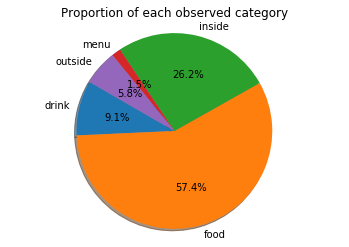

In [30]:
# Plot a pie chart to check proporation of each observed category

sizes = np.bincount(y)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=None, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion of each observed category')

plt.show()

In [26]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"


### Fire Module
1x1 sqeeze layer and 1x1, 3x3 expand convolution layers

In [27]:
# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    #squeeze layer
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    
    #expand layer
    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

In [53]:
def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)
    return model


### Architechture

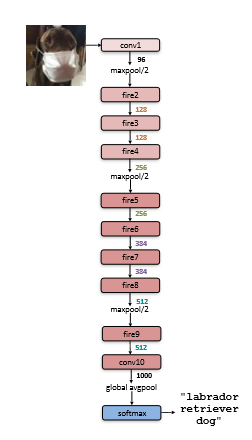

In [54]:
model = SqueezeNet()

In [56]:
img = image.load_img('_CF-BRZpfeezef9nn4CIqQ.jpg', target_size=(227, 227))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds))

Predicted: [[('n03871628', 'packet', 0.18813722), ('n07745940', 'strawberry', 0.17472747), ('n04204238', 'shopping_basket', 0.087715656), ('n03874293', 'paddlewheel', 0.068518035), ('n03920288', 'Petri_dish', 0.054815516)]]
